# Data Explorer

<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/modules/earthworm-giant-fiber-cap/Data-Explorer_earthworm-giant-fiber-cap.ipynb" target="_blank" rel="noopener noreferrer"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Get your bouts and trials here](#one)
- [CAP analysis](#two)


<a id="intro"></a>
# Giant Fiber System Activity

In this lab you measured the activity of the giant fiber system using extracellular differential electrodes. The activity that you will observe in your recording is referred to as a **complex action potential** (CAP). You will apply your knowledge from the previous labs to interpret this signal. The main goal of today is to analyze ***conduction velocity*** of the Giant Fiber system. One of the predominant analysis frameworks you will use is comparing *trials* across *bouts*.

<a id="setup"></a>
# Setup

[toc](#toc)

## Import and define functions

In [3]:
#@title {display-mode: "form" }

#@markdown Run this code cell to import packages and define functions 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.signal import hilbert,medfilt,resample, find_peaks, unit_impulse
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()
import matplotlib.pyplot as plt
import random
from numpy import NaN

from pathlib import Path

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from ipywidgets import widgets, interact, interactive
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Task completed at 2022-09-23 15:09:34.568010-05:00


## Mount Google Drive

In [ ]:
#@title {display-mode: "form" }

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

## Import data 

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

> If you would like to explore the analysis for this lab, but do not have data, you can download examples for the following experiments using the linked shared file:
    - [CAP measured at different distances from the stimulating electrodes](https://drive.google.com/file/d/1vBGixwIYyCldCHXgx6gMjrcMSlEu9UIs/view?usp=sharing). If you are using this example file, the sample rate was 30000 with three channels (channel 0 and 1 was the nerve signal and channel 2 was the stimulus monitor). The distance between stimulation and ch0 measurement electrodes was 3 cm. The distance between the two measurement electrodes was 4 cm. 

In [4]:
#@title {display-mode: "form" }

#@markdown Specify the file path 
#@markdown to your recorded data in the colab runtime (find the filepath in the colab file manager):

filepath = "full filepath goes here"  #@param 
# filepath = '/Volumes/Untitled/BIOL247/data/earthworm-giant-fiber-cap/diff_cv_0.bin'  #@param 
# filepath = '/Volumes/Untitled/BIOL247/data/earthworm-giant-fiber-cap/manual_post_2chan_same-pol_0.bin'

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = NaN #@param
number_channels = NaN #@param

# sampling_rate = 30000 #@param
# number_channels = 3 #@param

# downsample = False #@param
# newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
# if downsample:
#     # newfs = 10000 #downsample emg data
#     chunksize = int(sampling_rate/newfs)
#     data = data[0::chunksize,:]
#     fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

duration of recording was 57.50 seconds
Data upload completed at 2022-09-23 15:09:41.210640-05:00


## Plot raw data

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot the imported data. <br> 
#@markdown Use the range slider to scroll through the data in time.
#@markdown Use the channel slider to choose which channel to plot
#@markdown Be patient with the range refresh... the more data you are plotting the slower it will be. 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=True,
    continuous_update=False,
    description='Time Range (s)')
slider_xrange.layout.width = '600px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    continuous_update=False,
    description='channel')
slider_chan.layout.width = '300px'

# a function that will modify the xaxis range
def update_plot(x,chan):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    starti = int(x[0]*fs)
    stopi = int(x[1]*fs)
    ax.plot(time[starti:stopi], data[starti:stopi,chan])

w = interact(update_plot, x=slider_xrange, chan=slider_chan);

For a more extensive ***RAW*** Data Explorer than the one provided in the above figure, use the [DataExplorer.py](https://raw.githubusercontent.com/neurologic/Neurophysiology-Lab/main/howto/Data-Explorer.py) application found in the [howto section](https://neurologic.github.io/Neurophysiology-Lab/howto/Dash-Data-Explorer.html) of the course website.

<a id="one"></a>
# Part I. Get your bouts and trials here

The presentation of each stimulus marks the start of each ***trial*** in your experiment. Changes in stimulus parameters mark the start/end of different ***bouts*** in your experiment. 

Therefore, our first task in processing and analyzing data from the experiment is to figure out the trial times. You will do this using the same algorithm that you used to detect EOD events in the last lab. In this analysis, you will be processing the stimulus monitor signal directly.

## Define trial times

In [5]:
#@title {display-mode: "form"}

#@markdown Run this cell to create an interactive plot with a slider to scroll 
#@markdown through the signal on a selected trial
#@markdown and set an appropriate event detection threshold for trial onsets 
#@markdown (based on a positive-going level crossing of the signal). 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 0.5,
    readout=True,
    continuous_update=False,
    description='Time Range (s)',
    style = {'description_width': '200px'})
slider_xrange.layout.width = '600px'

# slider_yrange = widgets.FloatRangeSlider(
#     min=np.min(stim)-0.5,
#     max=np.max(stim)+0.5,
#     value=[np.min(stim),np.max(stim)],
#     step=0.05,
#     continuous_update=False,
#     readout=True,
#     description='yrange',
#     style = {'description_width': '200px'})
# slider_yrange.layout.width = '600px'

select_channel = widgets.Select(
    options=np.arange(np.shape(data)[1]), # start with a single trial on a single bout... it will update when runs ; old: np.arange(len(trial_times)),
    value=0,
    #rows=10,
    description='Channel used to detect trials',
    style = {'description_width': '200px'},
    disabled=False
)

slider_threshold = widgets.FloatSlider(
    min=-2,
    max=2,
    value=0.2,
    step=0.001,
    readout_format='.3f',
    continuous_update=False,
    readout=True,
    description='peak detection threshold',
    style = {'description_width': '200px'})
slider_threshold.layout.width = '600px'

detect_type_radio = widgets.RadioButtons(
    options=['peaks', 'level crossing'],
    value='level crossing', # Defaults to 'level crossing'
    layout={'width': 'max-content'}, # If the items' names are long
    description='Type of event detection',
    style = {'description_width': '200px'},
    disabled=False
)

iei_text = widgets.Text(
    value='0.005',
    placeholder='0.005',
    description='min IEI (seconds',
    style = {'description_width': '200px'},
    disabled=False
)

def update_plot(chan_,xrange,thresh_,detect_type,iei):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    
    signal = data[:,chan_]
    signal = signal-np.median(signal)
    
    iei = float(iei)
    
    if iei>0.001:
        d = iei*fs #minimum time allowed between distinct events
        
        if detect_type == 'peaks':
            if thresh_ >=0:
                r = find_peaks(signal,height=thresh_,distance=d)
            if thresh_ <0:
                r = find_peaks(-1*signal,height=-1*thresh_,distance=d)
            trial_times = r[0]/fs

        if detect_type == 'level crossing':
            # get the changes in bool value for a bool of signal greater than threshold
            threshold_crossings = np.diff(signal > thresh_, prepend=False)
            # get indices where threshold crossings are true
            tcross = np.argwhere(threshold_crossings)[:,0]
            # get a mask for only positive level crossings
            mask_ = [signal[t+1]-signal[t] > 0 for t in tcross]
            # trial times are positive level crossings
            trial_times = tcross[mask_]/fs

        starti = int(xrange[0]*fs)+1
        stopi = int(xrange[1]*fs)-1
        ax.plot(time[starti:stopi], signal[starti:stopi], color='black')
        
        # ax.plot(tmp,color='black')
        ax.hlines(thresh_, time[starti],time[stopi],linestyle='--',color='green')
        ax.scatter(trial_times,[thresh_]*len(trial_times),marker='^',s=300,color='purple',zorder=3)
        # ax.set_ylim(yrange[0],yrange[1])
        ax.set_xlim(xrange[0],xrange[1])
        

        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

              
        return trial_times

w_trials_ = interactive(update_plot, chan_=select_channel, 
                        xrange=slider_xrange, 
                        thresh_=slider_threshold, detect_type = detect_type_radio, iei = iei_text);
display(w_trials_)

interactive(children=(Select(description='Channel used to detect trials', options=(0, 1, 2), style=Description…

In [6]:
#@title {display-mode: "form"}

#@markdown Run this cell to finalize the list of trial times 
#@markdown after settling on a channel and threshold in the interactive plot. <br> 
#@markdown This stores the trial times in an array called 'trial_times'.
trial_times = w_trials_.result



## Define Bouts

In [7]:
#@title {display-mode: "form"}

#@markdown Use the interactive plot of the stimulus monitor channel in the last section to determine 
#@markdown the start and stop time for each of the bouts in your experiment. 
#@markdown Specify the list of bout ranges as follows: [[start of bout 0, end of bout 0],[start 1, end 1],...]] <br>

bouts_list = [[NaN,NaN]] #@param
# bouts_list = [[2,10],[10,20],[20,30],[30,45],[45,55],[55,70],[70,85],[85,100],[100,120]]
bouts_list = [[29.1,29.27],[38.5,38.7],[45,55]]

#@markdown Then run this code cell to programatically define the list of bouts as 'bouts_list'.

<a id="two"></a>
# Part II. CAP analysis

## Visualize Trials

In [28]:
#@title {display-mode:"form"}

#@markdown Run this code cell to create an interactive plot to  
#@markdown examine the CAP on individual trials for each bout.
#@markdown You can overlay multple channels by selecting more than one.
#@markdown You can overlay multiple trials by selecting more than one. 
#@markdown (To select more than one item from an option menu, press the control/command key 
#@markdown while mouse clicking or shift while using up/down arrows)

slider_xrange = widgets.FloatRangeSlider(
    min=-0.01,
    max=0.05,
    value=(-0.001,0.03),
    step=0.0005,
    continuous_update=False,
    readout=True,
    readout_format='.4f',
    description='xrange (s)'
)
slider_xrange.layout.width = '600px'

slider_yrange = widgets.FloatRangeSlider(
    min=-1,
    max=1, # normal range for earthworm experiments
    value=(-0.5,0.5),
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange'
)
slider_yrange.layout.width = '600px'

# trials in bout 0 to start...
trials_t = trial_times[(trial_times>bouts_list[0][0]) & (trial_times<bouts_list[0][1])]

select_channels = widgets.SelectMultiple(
    options=np.arange(np.shape(data)[1]), # start with a single trial on a single bout... it will update when runs ,
    value=[0],
    #rows=10,
    description='Channels',
    disabled=False
)

select_bouts = widgets.Select(
    options=np.arange(len(bouts_list)), # start with a single trial on a single bout... it will update when runs ; old: np.arange(len(trial_times)),
    value=0,
    #rows=10,
    description='Bouts',
    disabled=False
)

select_trials = widgets.SelectMultiple(
    options=np.arange(len(trials_t)), # start with a single trial on a single bout... it will update when runs ,
    value=[0],
    #rows=10,
    description='Trials',
    disabled=False
)

slider_threshold = widgets.FloatSlider(
    min=-0.3,
    max=0.3,
    value=0.1,
    step=0.001,
    readout_format='.3f',
    continuous_update=False,
    readout=True,
    description='peak detection threshold',
    style = {'description_width': '200px'})
slider_threshold.layout.width = '600px'

detect_chan_radio = widgets.RadioButtons(
    options=['0', '1', '2', 'none'],
    value='none', # Defaults to 'none'
    layout={'width': 'max-content'}, # If the items' names are long
    description='detect delay to peaks on channel: ',
    style = {'description_width': '400px'},
    disabled=False
)

trial_readout = widgets.Label(
    value=f'time since last trial is: {NaN}'
)
trial_readout.layout.width = '600px'

lagging_readout = widgets.Label(
    value=f'lagging peak times are: {NaN}'
)
lagging_readout.layout.width = '600px'

def update_plot(chan_list,trial_list,bout_,yrange,xrange,lagging_chan_,thresh_):
    fig, ax = plt.subplots(figsize=(8,4))# ,ncols=1, nrows=1); #specify figure number so that it does not keep creating new ones
 
    win_0 = int(xrange[0]*fs)
    win_1 = int(xrange[1]*fs)
    xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))
    
    trials_t = trial_times[(trial_times>bouts_list[bout_][0]) & (trial_times<bouts_list[bout_][1])]
    trials_init_ = np.arange(len(trials_t))
    select_trials.options = trials_init_
    
    trial_list = [t_try for t_try in trial_list if t_try in trials_init_]
    select_trials.value = trial_list
    
    
    value=f'time since last trial is: {NaN}'
    
    channel_colors = ['purple','green','blue','orange']
    for chan_ in chan_list:
        this_chan = data[:,chan_]
        for trial_ in trial_list:
            if trial_ in trials_init_:
                t_ = trials_t[trial_]

                if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<len(this_chan):
                    data_sweep = this_chan[(int(fs*t_)+win_0):(int(fs*t_)+win_1)]

                    ax.plot(xtime,data_sweep,color=channel_colors[chan_],linewidth=2,alpha=0.5)
    
    d = 0.003*fs
    if (lagging_chan_ != 'none') & (len(trial_list)==1):
        ax.hlines(thresh_, xrange[0],xrange[1],linestyle='--',color='green')
        lagging_chan_ = int(lagging_chan_)
        lagging_signal = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),lagging_chan_]
        if thresh_ >=0:
            r = find_peaks(lagging_signal,height=thresh_,distance=d)
            lagging_peak_amp = r[1]
        if thresh_ <0:
            r = find_peaks(-1*lagging_signal,height=-1*thresh_,distance=d)
            lagging_peak_amp = -1*r[1]['peak_heights']
            # print(r)
            
        lagging_peak_times = [np.round(xtime[lt],5) for lt in r[0]]#r[0]/fs
        lagging_readout.value=f'lagging peak times are: {lagging_peak_times}'
        
        if trial_list[0] == 0:
            trial_readout.value=f'time since last trial is: {NaN}'
        if trial_list[0] > 0:
            iti = trials_t[trial_list[0]] - trials_t[trial_list[0]-1]
            trial_readout.value=f'time since last trial is: {iti:.5f}'
        
        for lt_ in lagging_peak_times:
            ax.scatter(lagging_peak_times,lagging_peak_amp,color='black',s=50,zorder=3)
    

    ax.set_ylim(yrange[0],yrange[1]);
    ax.set_xlabel('seconds')
    # ax.vlines(0,yrange[0],yrange[1],color='black')

    
#     # Change major ticks to show every 20.
    # ax_pwm.xaxis.set_major_locator(MultipleLocator(5))
    # ax_pwm.yaxis.set_major_locator(MultipleLocator(5))

    # # Change minor ticks to show every 5. (20/4 = 5)
    # ax_mro.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    # ax_pwm.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # Turn grid on for both major and minor ticks and style minor slightly
# #     # differently.
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle=':')
#     ax_pwm.grid(which='major', color='gray', linestyle='-')
#     ax_pwm.grid(which='minor', color='gray', linestyle=':')


w = interact(update_plot, chan_list=select_channels,trial_list=select_trials, bout_=select_bouts, 
             yrange=slider_yrange, xrange = slider_xrange,lagging_chan_=detect_chan_radio,thresh_=slider_threshold);
# display(w)
display(trial_readout,lagging_readout)

interactive(children=(SelectMultiple(description='Channels', index=(0,), options=(0, 1, 2), value=(0,)), Selec…

Label(value='time since last trial is: nan', layout=Layout(width='600px'))

Label(value='lagging peak times are: nan', layout=Layout(width='600px'))

## Visualize Trials Across Bouts

The following code cell will overlay the trial data from multiple channels, bouts, and trials. Each channel will be plotted on a different subplot. Each bout will be a different color. Specified trials will be averaged within each bout. 

In [ ]:
#@title {display-mode:"form"}

#@markdown Specify which channels you want to visualize.
channel_list = [NaN] #@param
#@markdown Specify which bouts you want to visualize. 
bouts_all = [NaN] #@param
#@markdown Specify which trials you want to visualize for each bout. 
#@markdown <br> Note that there must be a list of trials for every bout.
trials_all = [[NaN]] #@param
#@markdown Specify the time range around each trial time that you want to include in the plot. 
xrange = [0,0.006] #@param

#@markdown Now run this code cell to create a plot that shows the trial-averaged response on each bout

win_0 = int(xrange[0]*fs)
win_1 = int(xrange[1]*fs)
xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))

fig, ax = plt.subplots(figsize=(15,8),nrows=len(channel_list),ncols=1)

for j,chan_ in enumerate(channel_list):
    
    this_chan = data[:,chan_]
    
    for i,bout_ in enumerate(bouts_all):
        data_avg = []
        trial_list = trials_all[i]
        trials_t = trial_times[(trial_times>bouts_list[bout_][0]) & (trial_times<bouts_list[bout_][1])]
        for trial_ in trial_list:

            t_ = trials_t[trial_]


            if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<len(this_chan):
                # sweep = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),mro_channel] 
                data_sweep = this_chan[(int(fs*t_)+win_0):(int(fs*t_)+win_1)]
                data_avg.append(data_sweep)
        data_avg = np.asarray(data_avg).T
        
        if len(channel_list)>1:
            ax[j].plot(xtime,np.mean(data_avg,1),linewidth=2,label = f'bout {bout_}')
        if len(channel_list)==1:
            ax.plot(xtime,np.mean(data_avg,1),linewidth=2,label = f'bout {bout_}')

    
    if len(channel_list)>1:

        # ax.set_ylim(yrange[0],yrange[1]);
        ax[j].set_xlabel('seconds')
        ax[j].legend()
        # ax.vlines(0,yrange[0],yrange[1],color='green')
        ax[j].xaxis.set_major_locator(MultipleLocator(0.002))
        ax[j].xaxis.set_minor_locator(AutoMinorLocator(10))
        ax[j].grid(which='major', color='gray', linestyle='-')
        ax[j].grid(which='minor', color='gray', linestyle=':')

if len(channel_list)==1:
    # ax.set_ylim(yrange[0],yrange[1]);
    ax.set_xlabel('seconds')
    ax.legend()
    # ax.vlines(0,yrange[0],yrange[1],color='green')
    ax.xaxis.set_major_locator(MultipleLocator(0.002))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle=':')

# Read and plot from .csv file

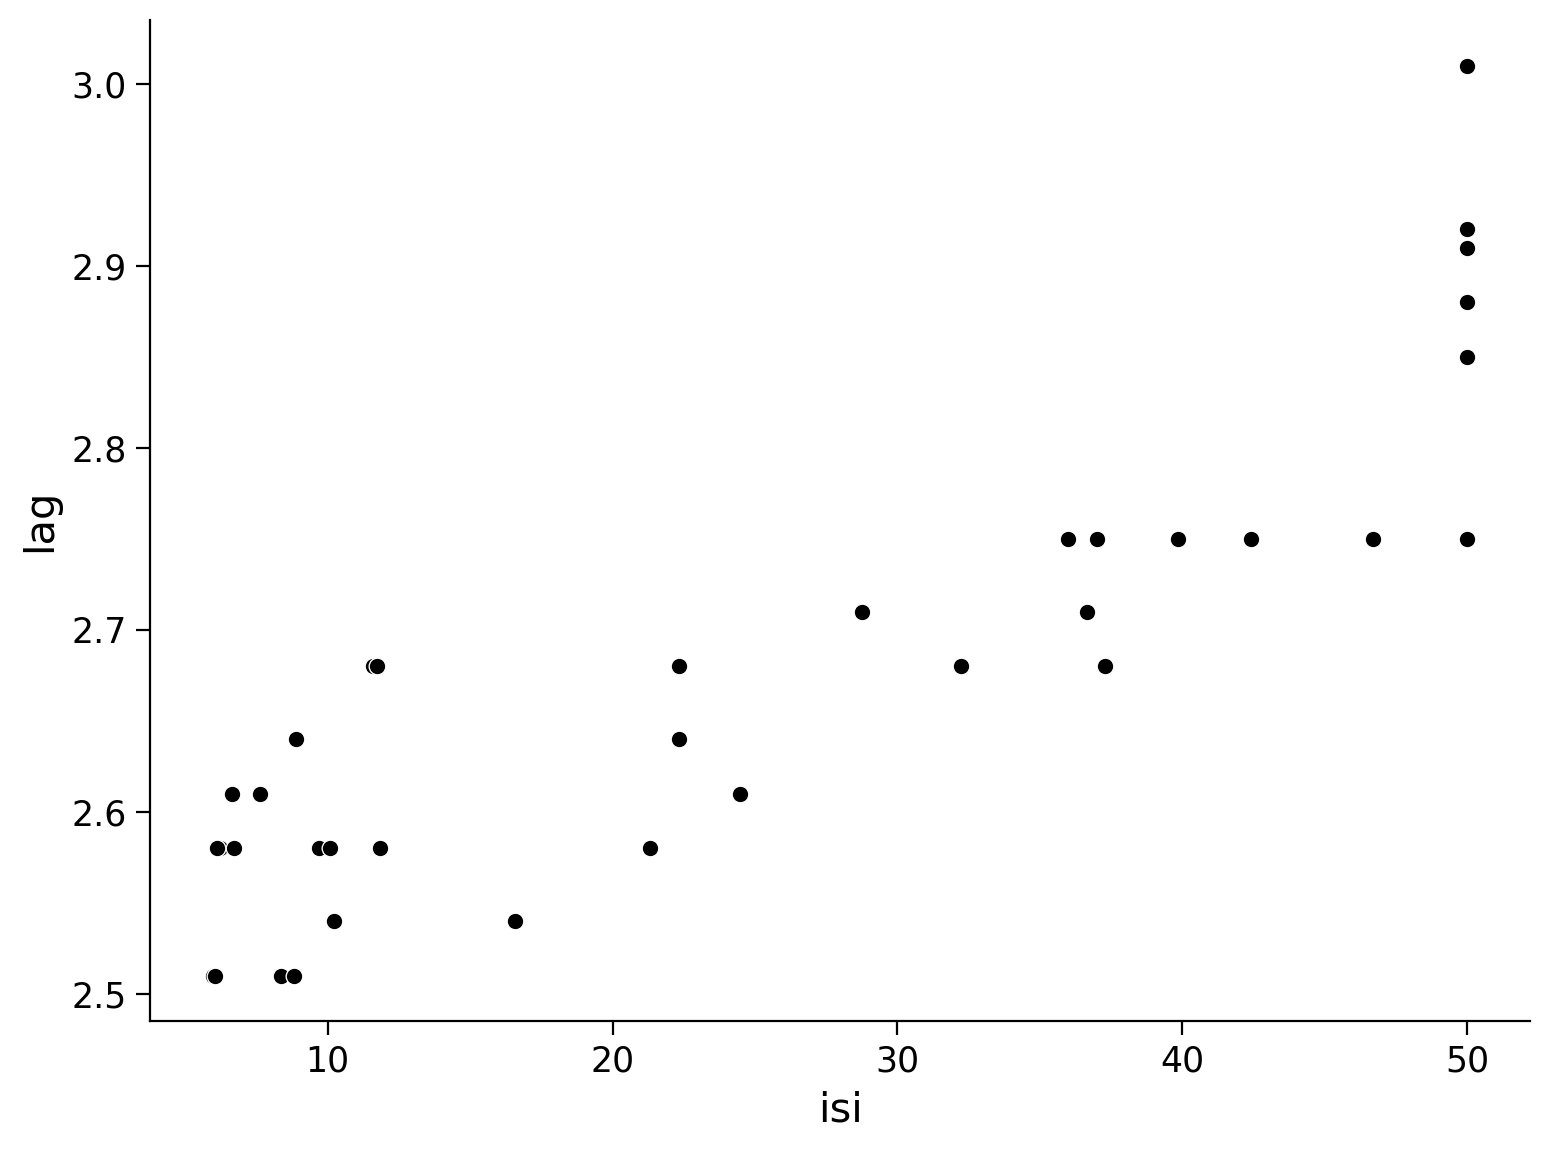

In [36]:
#@title {display-mode:"form"}

#@markdown Speficy the filepath to a csv file
filepath = '/Users/kperks/Documents/Teaching/Neurophysiology-Lab/modules/earthworm-giant-fiber-cv/LGF-cv-isi.csv' #@param
#@markdown Speficy the header name of the column you want for your x points
x_column = 'isi' #@param
#@markdown Speficy the header name of the column you want for your y points
y_column = 'lag' #@param

df = pd.read_csv(filepath)
sns.scatterplot(x=x_column,y=y_column,data=df,color='black');

<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.

<a id="setup"></a>

<a id="one"></a>

<a id="two"></a>

<a id="three"></a>

<a id="four"></a>